### Import Libs and Initializations

In [1]:
from pathlib import Path
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from typing import Union, Any, Dict
import ipywidgets as widgets
from utils import tiffread_utils, fft_funcs, glen_funcs

# currently unused
# import itertools
# import pickle
# import random


In [ ]:
bathy_dict = tiffread_utils.load_file(filename='BlueTopo_BH5245GN_20230804.tiff', 
                       folder='seafloor_files', 
                       verbose=False)
depth = tiffread_utils.remove_edge_Nans(depth=bathy_dict['depth'], ndv=bathy_dict['ndv'])

In [ ]:


resolution = bathy_dict['resolution']
desired_linespacing_meters = 515
multiples = [1, 2, 4]
max_multiple = 1
column_indices = fft_funcs.get_column_indices(array_len=depth.shape[1], 
                                    resolution=resolution, 
                                    linespacing_meters=desired_linespacing_meters, 
                                    max_multiple= max_multiple,
                                    verbose=False)

column_ranges = list(zip(column_indices[:-1], column_indices[1:]))

# selection = 'index'
selection = 'half'

# create placeholder for output
output = np.zeros_like(depth)
output[:] = np.nan
output2 = output.copy()
residuals = output.copy()


# for data strip, dimension is the same as linespacing so multiple=1
for col_range in column_ranges:
    segment_data = fft_funcs.get_strip(depth, column_indices=col_range, multiple=1, verbose=False)
    residual_data, interpolated  = fft_funcs.compute_residual(segment_data, verbose=False)
    # print(f"residual_data shape: {residual_data.shape}")
    # window_data = get_strip(depth, column_indices=col_range, multiple=max_multiple, verbose=False, row=row)
    # residual_data2, interpolated2 = get_interpolation_residual(window_data, verbose=False)
    residuals[:, col_range[0]:col_range[1]+1] = residual_data
    output[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(glen_funcs.glen_get_uncertainties, axis=1, 
                                                                 arr=residual_data, 
                                                                 resolution=resolution, 
                                                                 multiple=max_multiple,
                                                                 method='psd')
    output2[:, col_range[0]:col_range[1]+1] = np.apply_along_axis(fft_funcs.compute_fft_uncertainty, 
                                                                axis=1, arr=residual_data, 
                                                                multiple = max_multiple,
                                                                resolution=resolution, 
                                                                windowing='hann', 
                                                                method = 'spectrum',
                                                                selection = selection)


In [ ]:
fail_points_francis, errors_francis = glen_funcs.plot_uncertainty_comparison(residuals, output2)
fail_points_glen, errors_glen = glen_funcs.plot_uncertainty_comparison(residuals, output)

    


mean difference: 20362270.0


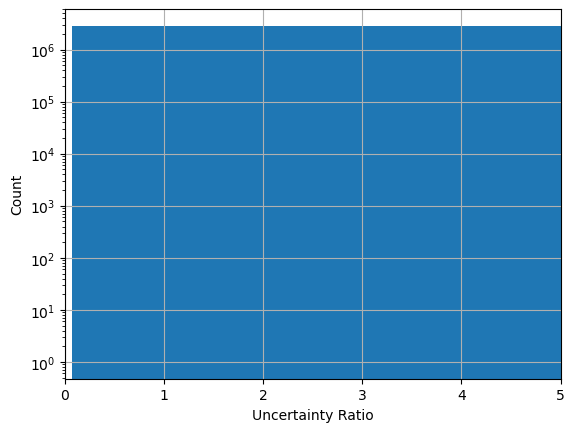

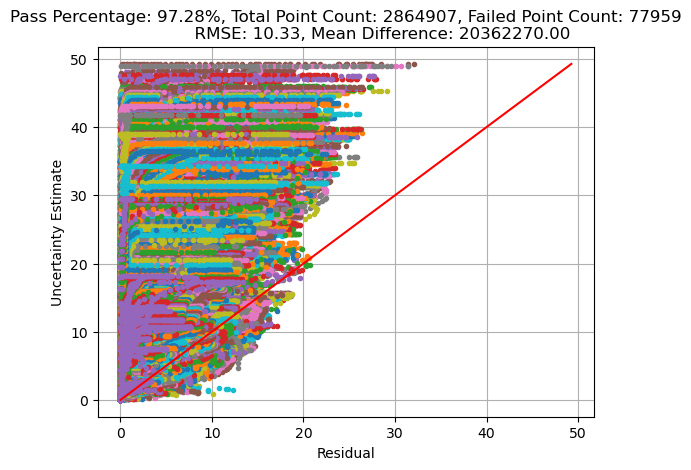

mean difference: 11666621.0


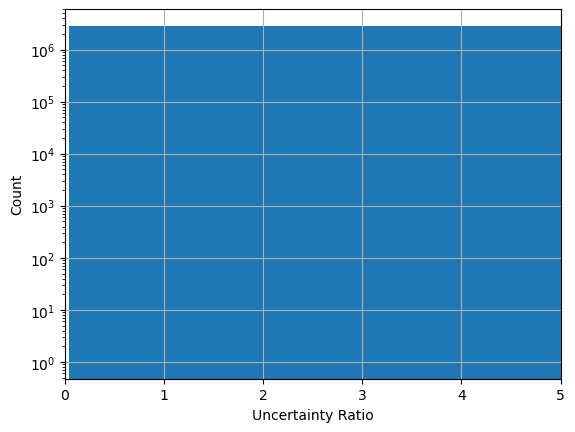

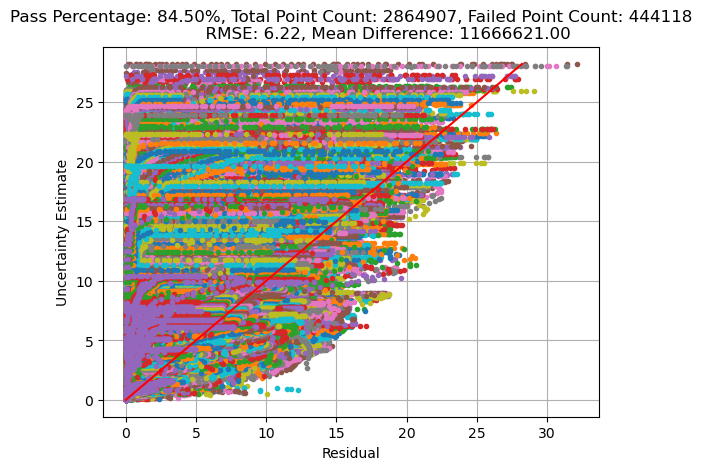

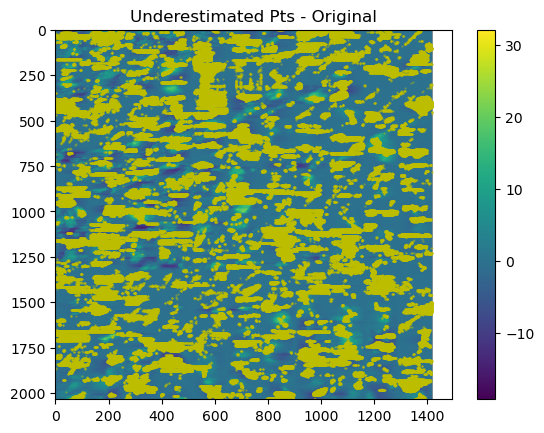

In [166]:
plt.figure()
plt.imshow(residuals, aspect='auto')
plt.colorbar()
# plt.plot(fail_points_francis[1], fail_points_francis[0], 'r.', alpha=0.5)
plt.plot(fail_points_glen[1], fail_points_glen[0], 'y.', alpha=0.5, markersize=1)
plt.title("Underestimated Pts - Original")
plt.show()

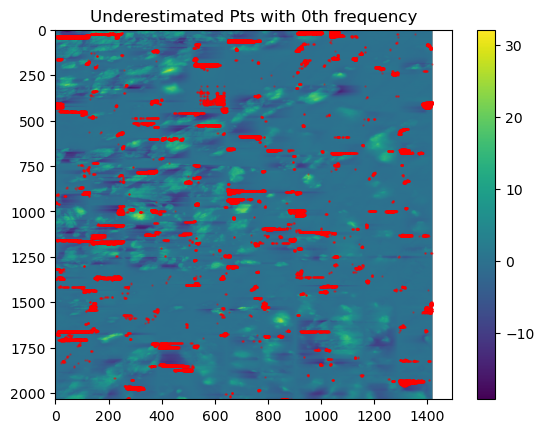

In [167]:
plt.figure()
plt.imshow(residuals, aspect='auto')
plt.colorbar()
plt.plot(fail_points_francis[1], fail_points_francis[0], 'r.', alpha=0.5, markersize=1)
# plt.plot(fail_points_glen[1], fail_points_glen[0], 'y.', alpha=0.5)
plt.title("Underestimated Pts with 0th frequency")
plt.show()

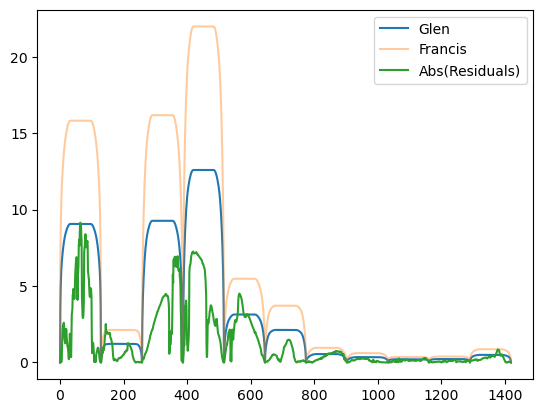

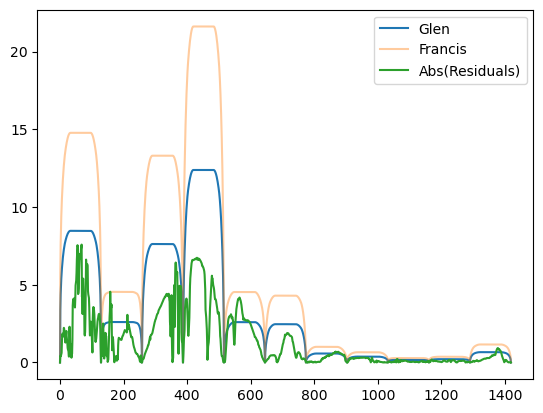

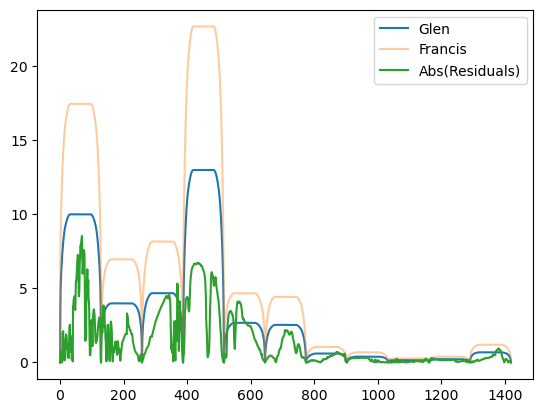

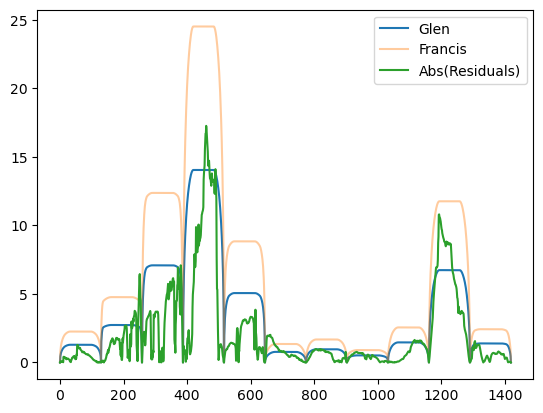

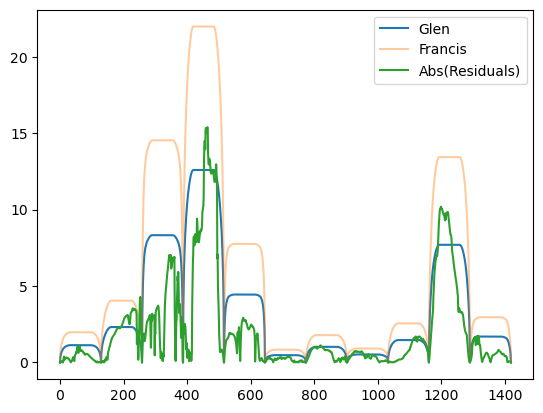

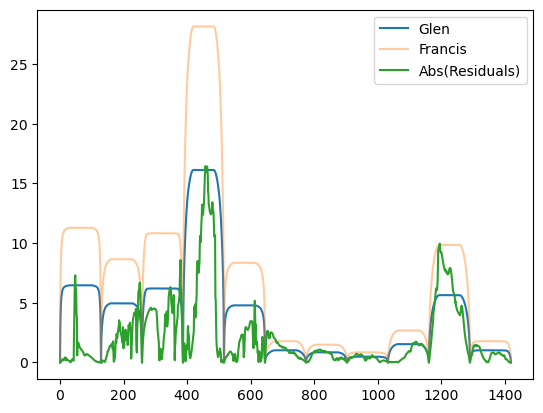

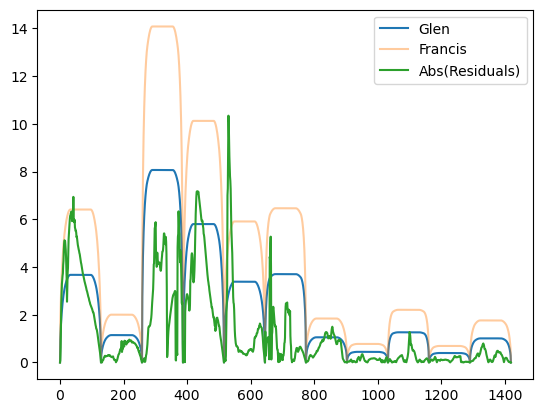

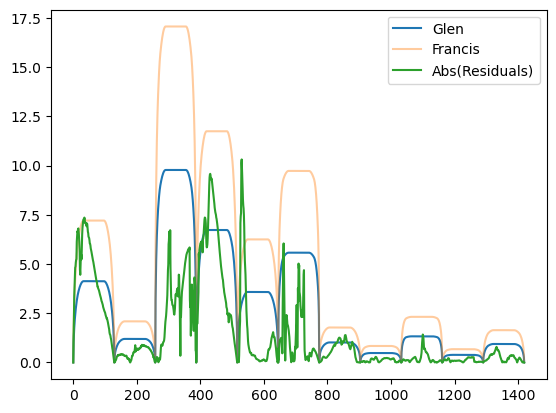

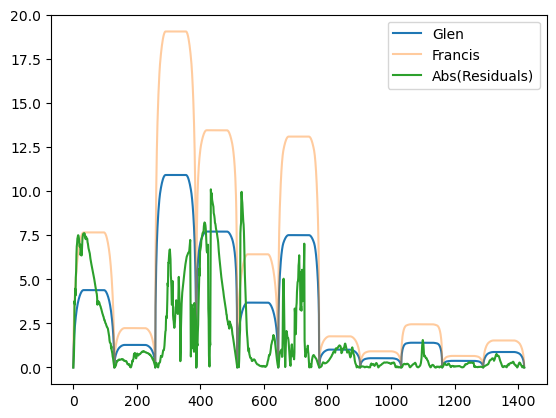

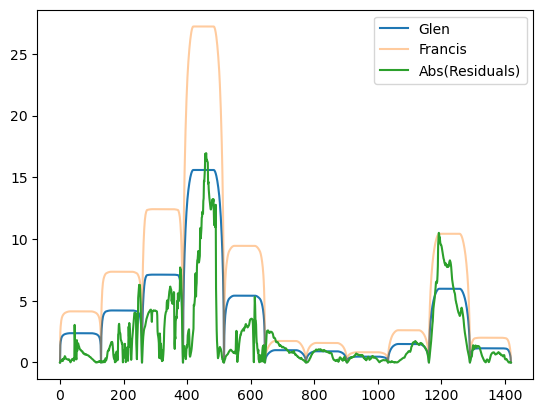

In [174]:
rows = [129, 125, 123, 653, 651, 656, 959, 960, 961, 655]
for row in rows:
    plt.figure()
    plt.plot(output[row], label='Glen')
    plt.plot(output2[row], '-', label='Francis', alpha=0.4)
    # plt.xlim(col_range[0]-10, col_range[1]+10)
    plt.plot(np.abs(residuals[row]), label='Abs(Residuals)')
    # plt.plot(np.abs(output), label='Abs(Residuals)')
    # plt.plot(output2, label='glen')
    # plt.vlines(column_indices, colors='gray', ymin=np.nanmin(output), ymax=np.nanmax(np.abs(output)), alpha=0.4)
    plt.legend()

In [280]:
files_folder = Path("seafloor_files") 
files_list = [(str(file.stem), str(file.name)) for file in files_folder.iterdir() if file.is_file()]
filename_selector = widgets.Dropdown(
    options=files_list,
    description='Surface:',
    disabled=False,
)

fft_methods_list = ['amplitude', 'density_trap', 'density_sum', 'spectrum']
fft_selector = widgets.Dropdown(
    options=fft_methods_list,
    description='PSD Method:',
    disabled=False,
    positioning='top'
)

window_size_selector = widgets.SelectionSlider(
    options=[1, 2, 4],
    description='Multiple',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

linespacing_selector = widgets.SelectionSlider(
    options=[32, 64, 128, 256, 512, 1024],
    description='Linespacing',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

row_selector = widgets.IntSlider(
    step=1,
    max=1000,
    value=400,
    description='Row Number:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

multiple_selector = widgets.SelectionSlider(
    options=[1, 2, 4],
    value=1,
    description='Multiple: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)


linespacing_selector = widgets.SelectionSlider(
    options=[32, 64, 128, 256, 512, 1024],
    value=512,
    description='Linespacing (m): ',
    style={'description_width': 'initial'},
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

range_selector = widgets.IntRangeSlider(
    value=[0, 2],
    min=0,
    max=2,
    step=1,
    description='Column Ranges',
    style={'description_width': 'initial'},
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)


# multiple_selector = widgets.RadioButtons(
#     options=[1, 2, 4],
# #    value='pineapple', # Defaults to 'pineapple'
# #    layout={'width': 'max-content'}, # If the items' names are long
#     description='Multiple',
#     disabled=False
# )

# items_layout = widgets.Layout( width='auto')     # override the default width of the button to 'auto' to let the button grow

# box_layout = widgets.Layout(display='flex',
#                     flex_flow='row', 
#                     align_items='stretch', 
#                     border='solid',
#                     width='50%')

# items = [filename_selector, fft_selector]
# box = widgets.Box(children=items, layout=box_layout)
# box  

@widgets.interact(filename=filename_selector, 
                  bathy_row=row_selector, 
                  multiple=multiple_selector, 
                  linespacing=linespacing_selector,
                  column_range=range_selector,
                  fft_method=fft_selector) 
def visualize_file(filename, bathy_row, multiple, linespacing, column_range, fft_method):
    bathy_file = BathyObject(filename=filename)
    row_selector.max = bathy_file.number_of_rows - 1
    current_row = bathy_row
    
    # VISUALIZE BATHYMETRY AND ROW NUMBER
    fig = plt.figure(figsize=(20, 10))
    ax1 = plt.subplot(231)
    im = ax1.imshow(bathy_file.bathy_data, cmap='terrain', aspect='equal')
    fig.colorbar(im, label='Depth (m)')
    locs = ax1.get_xticks()
    ax1.set_xticks(locs)
    ax1.set_xticklabels([int(x * bathy_file.resolution) for x in locs])
    locs = ax1.get_yticks()
    ax1.set_yticks(locs)
    ax1.set_yticklabels([int(y * bathy_file.resolution) for y in locs])
    # ax1.set_xticks(ax1.get_xticks())
    # ax1.set_yticks(ax1.get_yticks())
    # ax1.set_xticklabels([f"{x * bathy_file.resolution:.0f}" for x in ax1.get_xticks()])
    # ax1.set_yticklabels([f"{y * bathy_file.resolution:.0f}" for y in ax1.get_yticks()])
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_xlabel("West-East (m)")
    ax1.set_ylabel("North-South (m)")
    ax1.set_title(f"""
                Surface:{bathy_file.path.stem} at {bathy_file.resolution}m resolution
                Dimensions: {bathy_file.shape[0] * bathy_file.resolution/1000}km by {bathy_file.shape[1] * bathy_file.resolution/1000}km
                    """)
    plt.plot([0, bathy_file.number_of_columns-1], [current_row, current_row], color='red', linewidth=2)
    
    
    updated_line_spacings = [32, 64, 128, 256, 512, 1024]
    multiples = [1, 2, 4]
    multiple_selector.options = multiples
    linespacing_selector.options = updated_line_spacings
    Surface_Simulation.linespacing_meters_list = updated_line_spacings
    Surface_Simulation.multiplier_list = multiples
    current_surface = BathyObject(filename)
    sampling_columns = Surface_Simulation.determine_columns(bathy_object=current_surface, linespacing_meters=linespacing, max_multiple=np.max(multiple))
    range_selector.max = len(sampling_columns) 
    row_depth = bathy_file.bathy_data[current_row]
    residual_dict = Surface_Simulation.compute_residual_error_by_row(row_depth, sampling_columns)
    residual_row = residual_dict['residual_row']
    interpolated_row = residual_dict['interpolated_row']
    
    # PLOT ROW NUMBER AND INTERPOLATED
    ax2 = plt.subplot(232)
    ax2.plot(row_depth, label="Raw Depth")
    ax2.plot(sampling_columns, row_depth[sampling_columns], 'ro')
    ax2.plot(interpolated_row, label="Interpolated", color='orange')
    ax2.vlines(sampling_columns, ymin=np.min(row_depth),ymax=np.max(row_depth), color='gray', linestyle='--', alpha=0.2)
    locs = ax2.get_xticks()
    ax2.set_xticks(locs)
    ax2.set_xticklabels([int(x * bathy_file.resolution) for x in locs])
    locs = ax2.get_yticks()
    ax2.set_yticks(locs)
    # ax2.set_yticklabels([int(y * bathy_file.resolution) for y in locs])
    ax2.set_xlim(left=sampling_columns[column_range[0]], right=sampling_columns[column_range[1]-1])
    ax2.set_title(f"Row Number: {bathy_row}")
    ax2.set_xlabel("West-East (m)")
    ax2.set_ylabel("Depth (m)")
    plt.legend()
    
    # PLOT RESIDUAL AND WINDOWED VERSION
    # windowed = 
    ax3 = plt.subplot(233)
    ax3.plot(residual_row, label='Residual', color='brown')
    ax3.vlines(sampling_columns, ymin=np.nanmin(residual_row),ymax=np.nanmax(residual_row), color='gray', linestyle='--', alpha=0.2)
    ax3.hlines(y=0, xmin=0, xmax=len(residual_row), color='gray', linestyle='--', alpha=0.2)
    locs = ax3.get_xticks()
    ax3.set_xticks(locs)
    ax3.set_xticklabels([int(x * bathy_file.resolution) for x in locs])
    locs = ax3.get_yticks()
    ax3.set_yticks(locs)
    ax3.set_yticklabels([y * bathy_file.resolution for y in locs])
    ax3.set_ylabel("Residual Error (m)")
    ax3.set_xlabel("West-East (m)")
    ax3.set_title(f"Residual at Row {bathy_row}")
    ax3.set_xlim(left=sampling_columns[column_range[0]], right=sampling_columns[column_range[1]-1])
    plt.legend()
    
    
    # PLOT INPUT TO FFT
    ax4 = plt.subplot(235)
    ax4.plot(np.abs(residual_row), label='Residual', color='brown')
    
    fft_dict = Surface_Simulation.compute_fft_uncertainty_by_row(residual_row, sampling_columns, multiplier=multiple, fft_method=fft_method, resolution=int(seafloor_object.resolution))
    ax4.plot(fft_dict['uncertainty_row'], '--', label=f"uncertainty: {fft_method}")
    
    ax4.vlines(sampling_columns, ymin=np.nanmin(residual_row),ymax=np.nanmax(residual_row), color='gray', linestyle='--', alpha=0.2)
    ax4.hlines(y=0, xmin=0, xmax=len(residual_row), color='gray', linestyle='--', alpha=0.2)
    locs = ax4.get_xticks()
    ax4.set_xticks(locs)
    ax4.set_xticklabels([int(x * bathy_file.resolution) for x in locs])
    locs = ax4.get_yticks()
    ax4.set_yticks(locs)
    # ax4.set_yticklabels([y * bathy_file.resolution for y in locs])
    ax4.set_ylabel("Residual Error (m)- Absolute Value")
    ax4.set_xlabel("West-East (m)")
    ax4.set_title(f"Residual at Row {bathy_row}")
    ax4.set_xlim(left=sampling_columns[column_range[0]], right=sampling_columns[column_range[1]-1])
    plt.legend()
    
    
# def plot_uncertainties()
    
    
    
      
# widgets.interact(visualize_file, filename=filename_selector)


interactive(children=(Dropdown(description='Surface:', options=(('BlueTopo', 'BlueTopo.tiff'), ('BlueTopo_US5N…

In [ ]:


def visualize_row()

widgets.interact(visualize_row, filename=filename_selector, multiple=window_size_selector)
    

'Slopey_MA.tif'

In [41]:
int('−200')

ValueError: invalid literal for int() with base 10: '−200'

In [25]:
np.arange(0.05, 0.51, 0.05)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])